# CS-E4600 — Programming project

## Imports

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import scipy.sparse
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh
from scipy.cluster.vq import vq, kmeans, whiten
from scipy.sparse import coo_matrix

## Read file

In [82]:
#file = 'test'
#file = 'ca-GrQc'
#file = 'Oregon-1'
file = 'roadNet-CA'

## Read First line info and Edges

In [83]:
folder = './graphs_processed/'
with open(folder + file + '.txt') as f:
    first_line = f.readline()

splitted = first_line.split()

num_nodes = int(splitted[2])
num_edges = int(splitted[3])
k = int(splitted[4])
print(num_nodes, num_edges, k)

    
pd_edges = pd.read_csv(folder + file + '.txt', sep=" ", skiprows=range(0, 1), header=None)
pd_edges.columns = ["FromNodeId","ToNodeId"]
#pd_edges

1957027 2760388 50


## Select Distinct Nodes

In [84]:
node_candidates_1 = pd_edges.drop_duplicates(subset="FromNodeId")["FromNodeId"]
node_candidates_2 = pd_edges.drop_duplicates(subset="ToNodeId")["ToNodeId"]

In [85]:
pd_nodes = pd.concat([node_candidates_1, node_candidates_2])
pd_nodes = pd_nodes.drop_duplicates()
#pd_nodes

## Convert Nodes and Edges to Numpy

In [86]:
nodes = pd_nodes.values
edges = pd_edges.values
nodes2 = np.arange(num_nodes)
#print(nodes.shape, nodes.shape)
print(nodes)
print(nodes2)
nodes = nodes2
#nodes.shape, edges.shape

[      0       1       2 ... 1957015 1957024 1957023]
[      0       1       2 ... 1957024 1957025 1957026]


## Create Adjacency Matrix

what to do with too big arrays??

#adjacency_matrix = np.zeros((nodes.size, nodes.size))
#adjacency_matrix.shape

for i in range(0,edges.shape[0]):
    adjacency_matrix[edges[i,0], edges[i,1]] = 1
    adjacency_matrix[edges[i,1], edges[i,0]] = 1
#np.sum(adjacency_matrix)
plt.spy(adjacency_matrix,markersize=1)

In [87]:
row = np.concatenate((edges[:,0],edges[:,1]))
col = np.concatenate((edges[:,1],edges[:,0]))
data = np.ones((2*edges.shape[0]))

sparse_adjacency = coo_matrix((data, (row,col)), shape=(nodes.size, nodes.size))

## Create Laplacian Matrix

In [88]:
laplacian = csgraph.laplacian(sparse_adjacency, normed=False)
np.sum(laplacian)

0.0

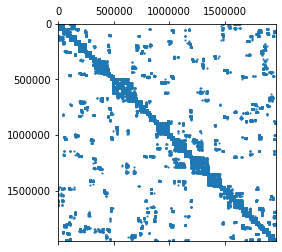

In [89]:
plt.spy(laplacian,markersize=1)

## Alternative way for the Laplacian Matrix

degrees = np.sum(adjacency_matrix, axis=0)
L_normed = np.identity((nodes.size))
for i in range(nodes.size):
    for j in range(nodes.size):
        if i != j and adjacency_matrix[i,j] == 1:
            L_normed[i,j] = -1.0/(np.sqrt(degrees[i]*degrees[j]))

degrees = np.sum(adjacency_matrix, axis=0)
L = degrees * np.identity((nodes.size))
for i in range(nodes.size):
    for j in range(nodes.size):
        if i != j and adjacency_matrix[i,j] == 1:
            L[i,j] = -1

np.sum(L_normed)

## Eigen-decomposition

_w, _v = np.linalg.eig(L_normed)

In [69]:
w, v = eigsh(laplacian, k, which="SA")
print(v)

[[ 9.68094584e-03 -6.89146096e-04  1.78083779e-03  1.21826156e-03
  -1.01740369e-03]
 [ 9.68094584e-03 -6.22955058e-04  1.59661140e-03  1.13077357e-03
  -8.89598335e-04]
 [ 9.68094584e-03 -6.31191283e-04  1.63497529e-03  1.15354645e-03
  -8.93792917e-04]
 ...
 [ 9.68094584e-03  2.63523689e-04  5.19780111e-05  1.56678156e-03
   7.77011424e-04]
 [ 9.68094584e-03  7.40917557e-04 -1.12398373e-04  1.57684263e-03
   8.16460178e-04]
 [ 9.68094584e-03 -1.03531985e-03  2.70477104e-03  2.49001827e-03
  -1.96381510e-03]]


plt.plot(w)
plt.show()

## Selects second smallest eigenvalue and corresponding eigenvector

In [70]:
eig_val_idx = np.argpartition(w,k-1)[1]
eig_val_idx
eig_vec = v[:,eig_val_idx]

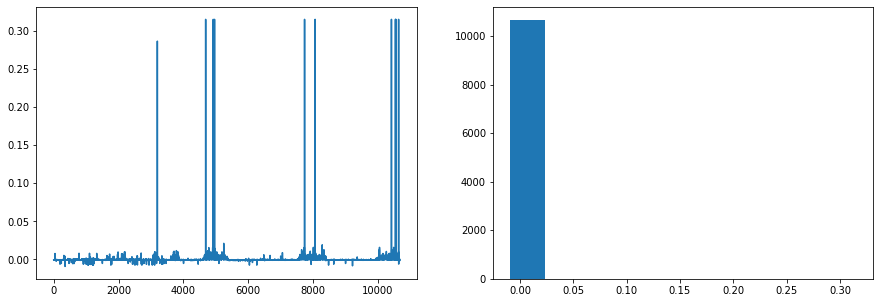

In [71]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(eig_vec)
plt.subplot(1, 2, 2)
plt.hist(eig_vec)
plt.show()

## K-means clustering

Should be improved to enforce balanced cluster sizes

In [72]:
whitened = whiten(v)
k_means, distortion = kmeans(v,k)
print(k_means)

[[ 0.00968095 -0.00582367  0.01752259 -0.07349259  0.00305932]
 [ 0.00968095  0.00636259 -0.05270686 -0.01143691  0.00655377]
 [ 0.00968095 -0.00066958  0.00168606  0.00133803 -0.00105762]
 [ 0.00968095  0.00054453 -0.00117413  0.0017017   0.00242182]
 [ 0.00968095  0.31240603  0.04305419 -0.01362404 -0.00520611]]


## Select cluster for all vertices

In [73]:
def cluster(node, k_means):
    node_cluster = 0
    node_distance = np.linalg.norm(node - k_means[0,:])
    
    for i in range(1,k_means.shape[0]):
        tmp_distance = np.linalg.norm(node - k_means[i,:])
        if (tmp_distance < node_distance):
            node_distance = tmp_distance
            node_cluster = i
                
    return node_cluster
        

In [74]:
clusters = np.zeros((num_nodes,1))
for j in range(clusters.size):
    clusters[j] = cluster(v[j,:], k_means)

In [75]:
unique, counts = np.unique(clusters, return_counts=True)

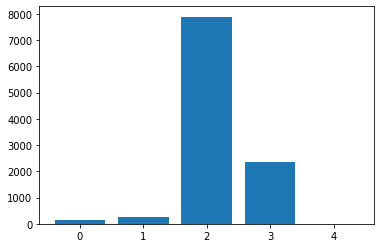

In [76]:
bars = np.arange(k)
plt.bar(bars, counts)
plt.show()

## Calculate cost for clusters

In [77]:
outer_edges = np.zeros((k,1))

for i in range(k):
    for j in range(num_edges):
        if(((clusters[edges[j,0]] == i) and (clusters[edges[j,1]] != i))
        or ((clusters[edges[j,0]] != i) and (clusters[edges[j,1]] == i))):
            outer_edges[i] += 1

In [78]:
counts = counts.reshape(k,-1)
costs = outer_edges / counts
cost = sum(costs)
print(outer_edges,"\n\n" ,  costs,"\n\n", cost)            

[[2.900e+01]
 [6.300e+01]
 [1.202e+03]
 [1.221e+03]
 [1.000e+00]] 

 [[0.1835443 ]
 [0.26141079]
 [0.15224826]
 [0.51606086]
 [0.1       ]] 

 [1.21326421]


In [79]:
all_edges = np.zeros((k,1))

for i in range(k):
    for j in range(num_edges):
        if((clusters[edges[j,0]] == i) or (clusters[edges[j,1]] == i)):
            all_edges[i] +=1
print(all_edges)

[[1.9700e+02]
 [3.8400e+02]
 [1.7298e+04]
 [5.3710e+03]
 [1.0000e+01]]


## Output clusters

In [80]:
#out_file = open("./results/" + file + ".output" + ".txt", "w")
out_file = open("./results/" + file + ".output", "w")
out_file.write(first_line)
for i in range (num_nodes):
    out_file.write(str(i) + " " + str(int(clusters[i,0])) + "\n")
out_file.close()